# Hello Soft Clustering (GMM)


### T1. Using 3 mixtures, initialize your Gaussian with means (3,3), (2,2), and (-3,-3), and standard Covariance, I, the identity matrix. Use equal mix- ture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j}$ , $m_j$ , $\vec{μ_j}$, $\Sigma_j$ for each EM iteration. (You may do the calculations by hand or write code to do so)


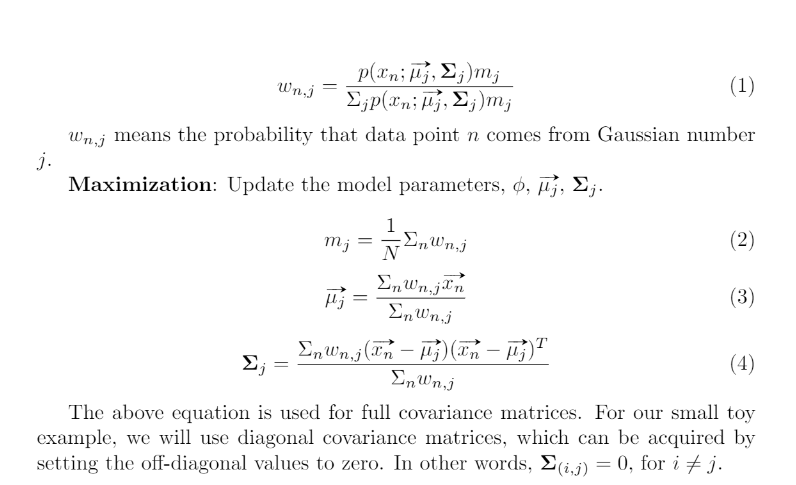


## TODO: Complete functions below including

- Fill relevant parameters in each function.
- Implement computation and return values.

These functions will be used in T1-4.


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Hint: You can use this function to get gaussian distribution.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
from scipy.stats import multivariate_normal

In [50]:
class GMM:
    def __init__(self, mixture_weight, mean_params, cov_params):
        """
        Initialize GMM.

        Args:
            mixture_weight (_type_): vector of mixture veight (x,y)
            mean_params (_type_): vector of mean of gaussian (x,y)
            cov_params (_type_): CoVarience Metrix where if row != col it is 0
        """
        # Copy construction values.
        self.mixture_weight = mixture_weight
        self.mean_params = mean_params
        self.cov_params = cov_params
        
        # Initiailize iteration.
        self.n_iter = 0
        
    @classmethod
    def gaussian_distribution_diagonal(cls, xy_vector, mean_j, cov_j, epsilon=1e-10):
        x, y = xy_vector
        sigma_x, sigma_y = np.sqrt(cov_j[0]), np.sqrt(cov_j[1])
        exponent = -0.5 * ((x - mean_j[0]) ** 2 / sigma_x**2 + (y - mean_j[1]) ** 2 / sigma_y**2)
        pdf = (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(exponent)
        
        # Check if pdf is less than epsilon, then return epsilon
        if pdf < epsilon:
            return epsilon
    
        return pdf

    def estimation_step(self, data):
        """
        Perform estimation step. Then, return w_{n,j} in eq. 1)

        Args:
            data (_type_): the (x,y) values 

        Returns:
            w metrix : metrix of probabitty where row is data Point i and col is gaussian mixture j 
        """

        # INSERT CODE HERE
        data_count = data.shape[0]
        mixture_count = len(self.mixture_weight)
        
        w = np.zeros((data_count, mixture_count))

        for j in range(mixture_count):
            prob_j = np.apply_along_axis(
                lambda dp: self.gaussian_distribution_diagonal(dp, self.mean_params[j], np.diag(self.cov_params[j])),
                axis=1,
                arr=data
            )
            w[:, j] = prob_j * self.mixture_weight[j]
        print("w_n,j metrix : \n",w)
        total_prob = np.sum(w, axis=1, keepdims=True)
        #print("total Prob = " , total_prob)
        w /= total_prob

        return w

    def maximization_step(self, data, w):
        """        
        Perform maximization step.
        (Update parameters in this GMM model.)

        Args:
            data (_type_): _description_
            w (_type_): _description_
        """
        # INSERT CODE HERE
        N = data.shape[0]
        mixture_count = len(self.mixture_weight)
        for j in range(mixture_count):
            sum_wnj = np.sum(w[:, j])
            self.mixture_weight[j] = sum_wnj / N

            sum_wnj_xn = np.sum(w[:, j, np.newaxis] * data, axis=0)
            self.mean_params[j] = sum_wnj_xn / sum_wnj

            diff_xn_mu_j = data - self.mean_params[j]
            sum_wnj_cov_j = np.sum(w[:, j, np.newaxis, np.newaxis] * np.einsum('...i,...j->...ij', diff_xn_mu_j, diff_xn_mu_j), axis=0) # calculate outter product and then element wise multiply by w of its n,j
            self.cov_params[j] = sum_wnj_cov_j / sum_wnj
        


    def get_log_likelihood(self, data):
        """
        Compute log likelihood.

        Args:
            data (numpy.ndarray): The input data.

        Returns:
            float: Log likelihood of the data given the current GMM parameters.
        """
        log_likelihood = 0

        data_count = data.shape[0]
        mixture_count = len(self.mixture_weight)

        for i in range(data_count):
            likelihood_i = 0
            for j in range(mixture_count):
                prob_ij = self.mixture_weight[j] * self.gaussian_distribution_diagonal(data[i], self.mean_params[j], np.diag(self.cov_params[j]))
                likelihood_i += prob_ij

            log_likelihood += np.log(likelihood_i)

        return log_likelihood

    def print_iteration(self):
        print("m (each mixture's weight) :\n", self.mixture_weight)
        print("mu (mean of each mixture):\n", self.mean_params)
        print("covariance matrix (of each mixture) :\n", self.cov_params)
        print("-------------------------------------------------------------")

    def perform_em_iterations(self, data, num_iterations, display=True):
        """
        Perform estimation & maximization steps with num_iterations.
        Then, return list of log_likelihood from those iterations.
        """
        log_prob_list = []

        # Display initialization.
        if display:
            print("Initialization")
            self.print_iteration()

        for n_iter in range(num_iterations):

            # TODO: Perform EM step.

            # INSERT CODE HERE
            
            #estimate
            w = self.estimation_step(data)
            
            #maximize
            self.maximization_step(data,w)


            # Calculate log prob.
            log_prob = self.get_log_likelihood(data)
            log_prob_list.append(log_prob)

            # Display each iteration.
            if display:
                print(f"Iteration: {n_iter}")
                self.print_iteration()

        return log_prob_list

In [51]:
num_iterations = 3
num_mixture = 3
mixture_weight = [1] * num_mixture # m
mean_params = np.array([[3,3], [2,2], [-3,-3]], dtype = float)
cov_params = np.array([np.eye(2)] * num_mixture)

X, Y = np.array([1, 3, 2, 8, 6, 7, -3, -2, -7]), np.array([2, 3, 2, 8, 6, 7, -3, -4, -7])
data = np.vstack([X,Y]).T

gmm = GMM(mixture_weight, mean_params, cov_params)
log_prob_list = gmm.perform_em_iterations(data, num_iterations)
print("log prob list is : \n" , log_prob_list)

Initialization
m (each mixture's weight) :
 [1, 1, 1]
mu (mean of each mixture):
 [[ 3.  3.]
 [ 2.  2.]
 [-3. -3.]]
covariance matrix (of each mixture) :
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
-------------------------------------------------------------
w_n,j metrix : 
 [[1.30642333e-02 9.65323526e-02 1.98968008e-10]
 [1.59154943e-01 5.85498315e-02 1.00000000e-10]
 [5.85498315e-02 1.59154943e-01 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10 1.00000000e-10]
 [1.96412803e-05 1.79105293e-08 1.00000000e-10]
 [1.79105293e-08 1.00000000e-10 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10 1.59154943e-01]
 [1.00000000e-10 1.00000000e-10 5.85498315e-02]
 [1.00000000e-10 1.00000000e-10 1.79105293e-08]]
Iteration: 0
m (each mixture's weight) :
 [0.38289983044864834, 0.2473427508531378, 0.3697574186982138]
mu (mean of each mixture):
 [[ 5.33805893  5.37264961]
 [ 2.61529639  3.01096734]
 [-2.76978836 -3.37078299]]
covariance matrix (of each mixture) :
 [[[ 4.52922311

### T2. Plot the log likelihood of the model given the data after each EM step. In other words, plot $\log \prod_n p( \vec{x_n} |φ, \vec{μ} , Σ)$. Does it goes up every iteration just as we learned in class?


In [52]:
# TODO
def plot_log_likelyhood(title,num_iterations_value,log_prob_list_vale):
    # Plot the log likelihood values
    print("log prob lists's values : \n", log_prob_list_vale)
    plt.plot(range(1, num_iterations_value + 1), log_prob_list_vale, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.title(f'Log Likelihood vs. Iteration ({title})')
    plt.show()


log prob lists's values : 
 [-47.19006137447039, -40.6235732615156, -35.326759107259505]


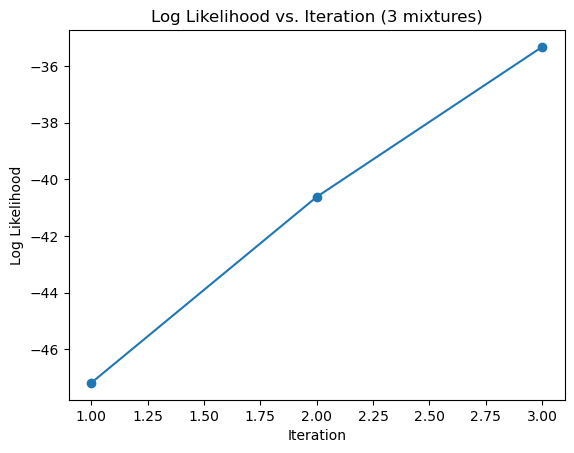

In [53]:
plot_log_likelyhood("3 mixtures",num_iterations,log_prob_list)

    ANS : Yes it does goes up or at least not decrease on every Iteration


### T3. Using 2 mixtures, initialize your Gaussian with means (3,3) and (-3,-3), and standard Covariance, I, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j}$ , $m_j$ , $\vec{μ_j}$, $\Sigma_j$ for each EM iteration.


In [54]:
num_mixture_T3 = 2
mixture_weight_T3 = [1] * num_mixture_T3

mean_params_T3 = np.array([[3,3], [-3,-3]], dtype = float)
cov_params_T3 = np.array([np.eye(2)] * num_mixture_T3)

# INSERT CODE HERE
gmm2 = GMM(mixture_weight_T3, mean_params_T3, cov_params_T3)
log_prob_list2 = gmm2.perform_em_iterations(data, num_iterations)

print("log prob list 2 is : \n" , log_prob_list2)

Initialization
m (each mixture's weight) :
 [1, 1]
mu (mean of each mixture):
 [[ 3.  3.]
 [-3. -3.]]
covariance matrix (of each mixture) :
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
-------------------------------------------------------------
w_n,j metrix : 
 [[1.30642333e-02 1.98968008e-10]
 [1.59154943e-01 1.00000000e-10]
 [5.85498315e-02 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10]
 [1.96412803e-05 1.00000000e-10]
 [1.79105293e-08 1.00000000e-10]
 [1.00000000e-10 1.59154943e-01]
 [1.00000000e-10 5.85498315e-02]
 [1.00000000e-10 1.79105293e-08]]
Iteration: 0
m (each mixture's weight) :
 [0.6111105437197949, 0.38888945628020505]
mu (mean of each mixture):
 [[ 4.16768335  4.34950169]
 [-2.26349302 -2.83492075]]
covariance matrix (of each mixture) :
 [[[ 6.44858613  5.87264319]
  [ 5.87264319  5.44546067]]

 [[21.7337554  21.5831882 ]
  [21.5831882  22.24894682]]]
-------------------------------------------------------------
w_n,j metrix : 
 [[4.54125583e-03 1.30275260e-03]
 [1.

### T4. Plot the log likelihood of the model given the data after each EM step. Compare the log likelihood between using two mixtures and three mixtures. Which one has the better likelihood?


log prob lists's values : 
 [-49.31011049071287, -47.30274527288658, -46.55520865423186]


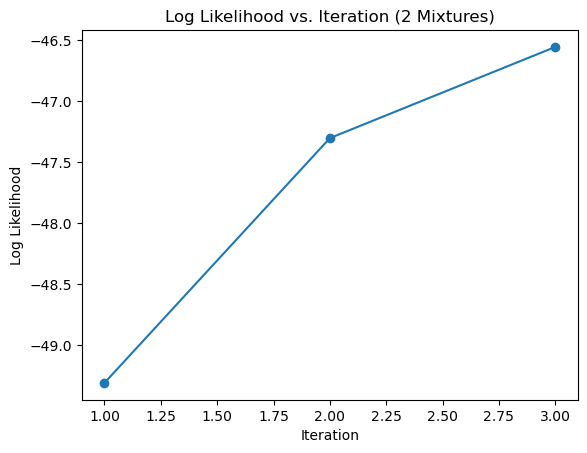

In [55]:
# TODO: Plot log_likelihood from T3
plot_log_likelyhood("2 Mixtures",num_iterations,log_prob_list2)

    Description : It does goes up or at least not decrease on every Iteration but not as aggressive as the T1's model


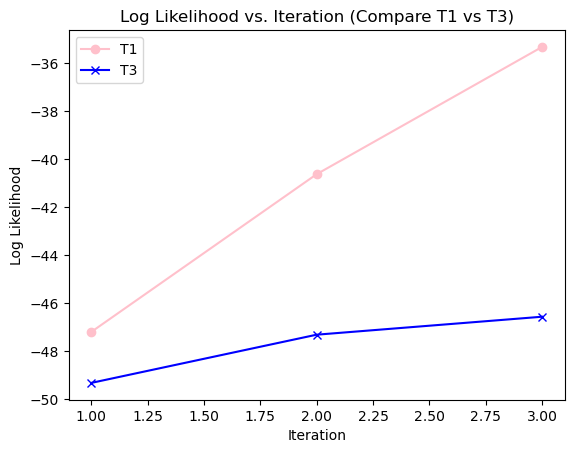

In [56]:
# TODO: Plot Comparision of log_likelihood from T1 and T3
def dual_plot_log_likelyhood(title,num_iterations_value,log_prob_list1,log_prob_list2):
    # Plot the log likelihood values
    plt.plot(range(1, num_iterations_value + 1), log_prob_list1, marker='o', color='pink',label="T1")
    plt.plot(range(1, num_iterations_value + 1), log_prob_list2, marker='x', color='blue',label="T3")
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.title(f'Log Likelihood vs. Iteration ({title})')
    plt.legend()
    plt.show()
    
dual_plot_log_likelyhood("Compare T1 vs T3",num_iterations,log_prob_list,log_prob_list2)

    ANS : From this datapoints using 3 mixtures yields better log likelyhood results than using just 2 even after the convergence

![Screenshot 2024-02-20 121648.png](<attachment:Screenshot 2024-02-20 121648.png>)

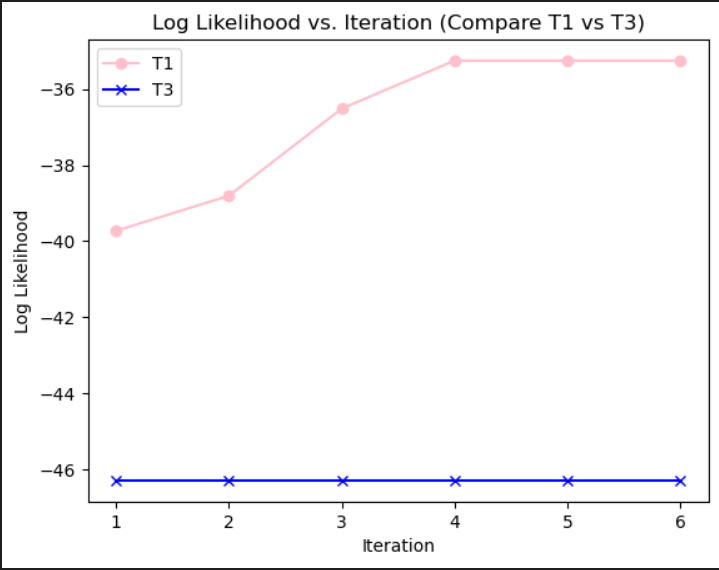

### OT1. Using 2 mixtures, initialize your Gaussian with means (0,0) and (10000,10000). Explain what happens. From this case, explain how a proper initialization should be performed. What other tricks can be used to prevent this from happening?


In [57]:
num_mixture_OT1 = 2
mixture_weight_OT1 = [1] * num_mixture_OT1

mean_params_OT1 = np.array([[0,0], [10000,100000]], dtype = float)
cov_params_OT1 = np.array([np.eye(2)] * num_mixture_OT1)

# INSERT CODE HERE
gmm_OT1 = GMM(mixture_weight_OT1, mean_params_OT1, cov_params_OT1)
log_prob_list_OT1 = gmm_OT1.perform_em_iterations(data, num_iterations)

print("log prob list 2 is : \n" , log_prob_list_OT1)

Initialization
m (each mixture's weight) :
 [1, 1]
mu (mean of each mixture):
 [[     0.      0.]
 [ 10000. 100000.]]
covariance matrix (of each mixture) :
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
-------------------------------------------------------------
w_n,j metrix : 
 [[1.30642333e-02 1.00000000e-10]
 [1.96412803e-05 1.00000000e-10]
 [2.91502447e-03 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10]
 [1.96412803e-05 1.00000000e-10]
 [7.22562324e-06 1.00000000e-10]
 [1.00000000e-10 1.00000000e-10]]
Iteration: 0
m (each mixture's weight) :
 [0.7777751040012956, 0.22222489599870443]
mu (mean of each mixture):
 [[1.14286501 1.00001133]
 [3.49994409 3.49993025]]
covariance matrix (of each mixture) :
 [[[16.69390042 17.57144315]
  [17.57144315 19.14285897]]

 [[37.24986938 37.24994549]
  [37.24994549 37.25004927]]]
-------------------------------------------------------------
w_n,j metrix : 
 [[6.74191256e-03 8.471092

    ANS : We see that On the estimation step when calculating the w_nj the gaussian mixture of (10000,10000)'s probability is approaching 0 (as it is very far away from the mean and the varience) since the first iteration. this causses the miscalculation of mean and covarience to be NaN.

Maybe we can fix this by flooring the possibility?
Imma try and then the results on the code should not be NaN after fix.

Results : I fuckin did it. We can see that now the probability and the EM process work as intended without any errors(T1 vs T3 after changes the code to floor possiblility)

![Screenshot 2024-02-20 163451.png](<attachment:Screenshot 2024-02-20 163451.png>)
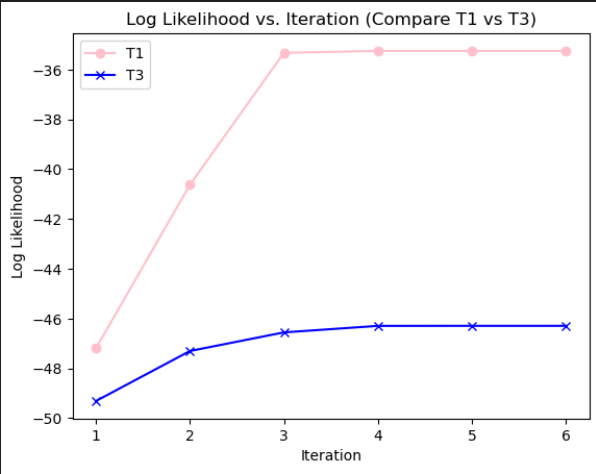

# The face database


In [58]:
# Download facedata for google colab
# !wget -nc https://github.com/ekapolc/Pattern_2024/raw/main/HW/HW03/facedata_mat.zip
# !unzip facedata_mat.zip

In [59]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_float

# Change path to your facedata.mat file.
facedata_path = 'facedata.mat'

data = scipy.io.loadmat(facedata_path)
data_size = data['facedata'].shape

%matplotlib inline
#data containing 40 person where each person got 10 poses. (each image is 57*45 something somthing)
data_size

(40, 10)

### Preprocess xf


In [60]:
#xf is a 4d metrix containing all 40 persons 10 image where each image is 50x45 somthing somthing
xf = np.zeros((data_size[0], data_size[1], data['facedata'][0,0].shape[0], data['facedata'][0,0].shape[1])) 
for i in range(data['facedata'].shape[0]):
    for j in range(data['facedata'].shape[1]):
        # rescale from 0-255 int to 0-1 float
        xf[i,j] = img_as_float(data['facedata'][i,j])
        

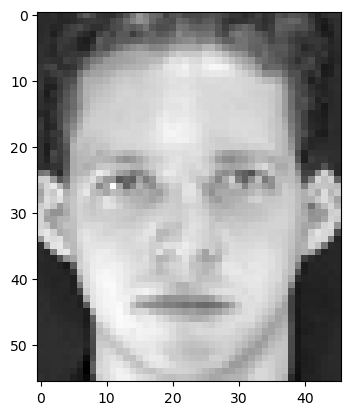

In [61]:
# Example: Ploting face image.
plt.imshow(xf[0,0], cmap = 'gray')
plt.show()

very handsome.


### T5. What is the Euclidean distance between xf[0,0] and xf[0,1]? What is the Euclidean distance between xf[0,0] and xf[1,0]? Does the numbers make sense? Do you think these numbers will be useful for face verification?


In [62]:
def flattening(x_n):
    """flatten a metrix of image in to a N*M dimensional vector

    Args:
        x_n (metrix M*N): image representation of the data
        
    Returns:
        x_vec (vector N*M dimension): flattened image ready to do vector cal
    """
    # Reshape the matrix into a vector
    x_vec = np.reshape(x_n, (-1,))
    
    return x_vec

def L2_dist(x1, x2):
    """TODO: Calculate L2 distance.

    Args:
        x1 (vector): vector 1 
        x2 (vector): vector 2

    Returns:
        euclidean_distance (float)): euclidean distance between 2 images
    """
    euclidean_distance = np.linalg.norm(x1 - x2)
    
    return euclidean_distance

# Test L2_dist
def test_L2_dist():
    assert L2_dist(np.array([1, 2, 3]), np.array([1, 2, 3])) == 0.0
    assert  L2_dist(np.array([0, 0, 0]), np.array([1, 2, 3])) == np.sqrt(14)

test_L2_dist()

print('Euclidean distance between xf[0,0] and xf[0,1] is', L2_dist(xf[0,0], xf[0,1]))
print('Euclidean distance between xf[0,0] and xf[1,0] is', L2_dist(xf[0,0], xf[1,0]))

Euclidean distance between xf[0,0] and xf[0,1] is 10.037616294165494
Euclidean distance between xf[0,0] and xf[1,0] is 8.173295099737283


(40, 10, 56, 46)


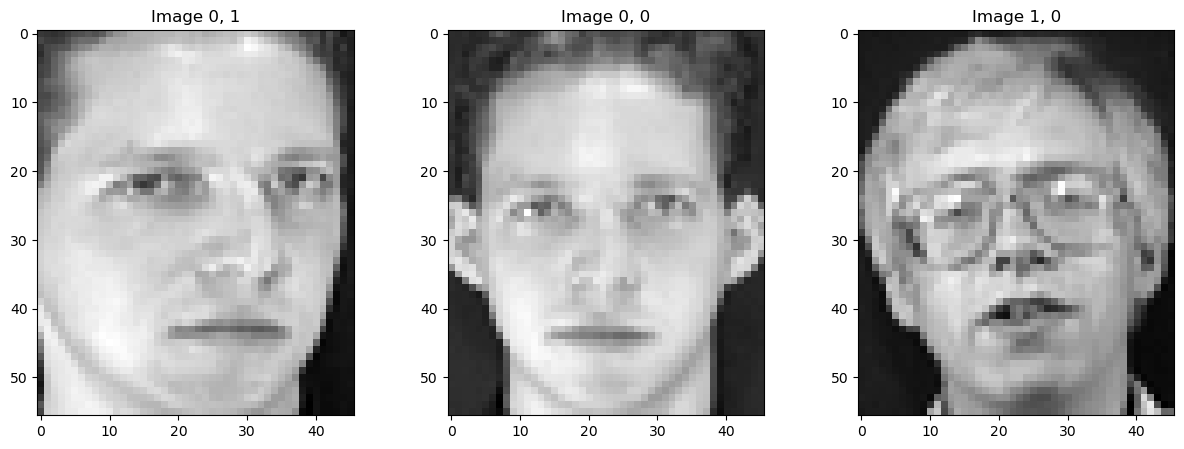

In [63]:
# TODO: Show why does the numbers make sense

print(xf.shape)
# Create a 1x3 subplot layout
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Subplot 1
plt.subplot(1, 3, 1)
plt.imshow(xf[0, 1], cmap='gray')
plt.title('Image 0, 1')
# Subplot 2
plt.subplot(1, 3, 2)
plt.imshow(xf[0, 0], cmap='gray')
plt.title('Image 0, 0')
# Subplot 3
plt.subplot(1, 3, 3)
plt.imshow(xf[1, 0], cmap='gray')
plt.title('Image 1, 0')

plt.show()

    ANS : 
    I mean... mathematically it does make sense as the L2 distance finds the sqared sum of the linear distance of "each pixels" where we value each pixels the same (same weight)
    so when distance of  xf[0,0] with xf[1,0] is closer than xf[0,0] with xf[0,1] ( which is the same person different pose) the different person is closer because probably the background of the two takes majority of the pixels and they have similar background in both photo. 
    
    Sooo as of right now The Euclidean distance maybe useful but we must first find a way to overcome the formentioned problem of some useless feature taking over the faces (or somting like that but I hope you get me naaa).


### T6. Write a function that takes in a set of feature vectors T and a set of feature vectors D, and then output the similarity matrix A. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people for list T (in order x[0, 0], x[0, 1], x[0, 2], x[1, 0], x[1, 1], ...x[39, 2]). Use the feature vectors from the remaining 7 images from all 40 people for list D (in order x[0, 3], x[0, 4], x[0, 5], x[1, 6], x[0, 7], x[0, 8], x[0, 9], x[1, 3], x[1, 4]...x[39, 9]). We will treat T as our training images and D as our testing images


In [64]:
def organize_shape(matrix):
    """
    TODO (Optional): Reduce matrix dimension of 2D image to 1D and merge people and image dimension.
    This function can be useful at organizing matrix shapes.

    Example:
        Input shape: (people_index, image_index, image_shape[0], image_shape[1])
        Output shape: (people_index*image_index, image_shape[0]*image_shape[1])
    """
    #reduce the dimension of people and image dimension by reshapeing it from (40,10,56,46) to (400,56*46) Dimension vector
    people_count, pose_count, img_x_count, img_y_count = matrix.shape
    reshaped_matrix = np.reshape(matrix, (people_count*pose_count,img_x_count*img_y_count))
    
    return reshaped_matrix


def generate_similarity_matrix(A, B):
    """
    TODO: Calculate similarity matrix M,
    which M[i, j] is a distance between A[i] and B[j].
    """
    # INSERT CODE HERE
    
    #Assume input is 2D 
    # each row is an img with (56*46 pixels)
    total_row_A, total_col_A = A.shape 
    total_row_B, total_col_B = B.shape 

    similarity_matrix = np.zeros((total_row_A, total_row_B))

    for i in range(total_row_A):
        for j in range(total_row_B):
            similarity_matrix[i][j] = L2_dist(A[i],B[j])

    return similarity_matrix

def test_generate_similarity_matrix():
    test_A = np.array([[1, 2],[3,4]])
    test_B = np.array([[1, 2], [5, 6], [7, 8]])
    expected_matrix = np.sqrt(np.array([[0, 32, 72], [8, 8, 32]]))
    assert (generate_similarity_matrix(test_A, test_B) == expected_matrix).all()

test_generate_similarity_matrix()

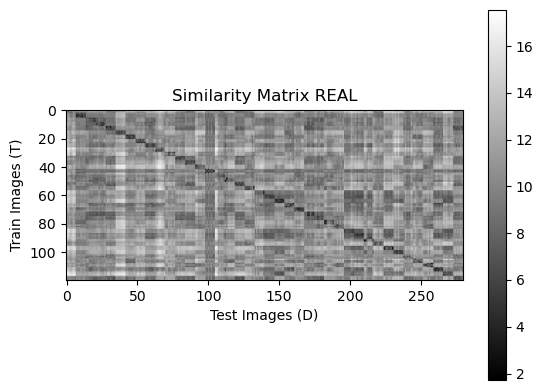

In [65]:
#TODO: Show similariry matrix between T and D.

# INSERT CODE HERE
def train_test_saparator(xf_matrix, train_amount=3, test_amount=7, pose_amount=10):
    """saperate a metrix into train and test set with 2D shape

    Args:
        xf_matrix (4D metrix): matrix containing image of each persons 
        train_amount (int, optional): img to select for each person's train set. Defaults to 3.
        test_amount (int, optional): img to select for each person's test set. Defaults to 7.
        pose_amount (int, optional): total img of each person . Defaults to 10. = (train_amount+test_amount)

    Returns:
        T (2D metrix): training data 
        D (2D metrix): test data
    """
    #first saparate between T and D right?
    T_matrix = xf_matrix[:,:train_amount]
    D_matrix = xf_matrix[:,train_amount:]
    
    T = organize_shape(T_matrix)
    D = organize_shape(D_matrix)
    
    return T,D

def plot_similarity_matrix(title,similarity_matrix):
    plt.imshow(similarity_matrix, cmap='gray')
    plt.colorbar()
    plt.title(f'Similarity Matrix {title}')
    plt.xlabel('Test Images (D)')
    plt.ylabel('Train Images (T)')
    plt.show()

T,D = train_test_saparator(xf)
similarity_matrix = generate_similarity_matrix(T,D)
plot_similarity_matrix("REAL",similarity_matrix)



### T7. From the example similarity matrix above, what does the black square between [5:10,5:10] suggest about the pictures from person number 2? What do the patterns from person number 1 say about the images from person 1?


        ANS : 
        for the black square between [5:10,5:10] it suggest that the 2 images are exactly the same distance == 0 as it is the same picture from the start (same pose and person)

        (starting index = 0)
        As for person 1 the pattern suggest that there is very little similarity between pose (3,4) and (1,3)
        but strong similarity between (0,2) and (1,4)




### T8. Write a function that takes in the similarity matrix created from the previous part, and a threshold t as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task (280 Test images, tested on 40 people, a total of 11200 testing per threshold). What is the true positive rate and the false alarm rate for t = 10?


In [66]:
def evaluate_performance(similarity_matrix, threshold):
    """TODO: Calculate true positive rate and false alarm rate from given similarity_matrix and threshold.

    Args:
        similarity_matrix (_type_): similarity_matrix
        threshold (_type_): minimum distance (between three training images)

    Returns:
        true_pos_rate
        false_neg_rate
    """

    #True Positive : model predict True and actual is also True
    TP = 0
    #False Negative : model predict False but actual is True
    FN = 0
    #True Negative : model predict False and the actual is False
    TN = 0
    #False Positive : model predict True but the actual is False
    FP = 0
    

    min_dist_matrix = np.zeros((40, similarity_matrix.shape[1]), dtype = int)
    min_dist_matrix = np.min(similarity_matrix.reshape((-1, 3, similarity_matrix.shape[1])), axis = 1)
    threshold_matrix = (min_dist_matrix < threshold).astype(int)
    
    total_pred = threshold_matrix.shape[0]
    total_label = threshold_matrix.shape[1]

    
    for i in range(40):
        #since each i_th person = col_index // 7
        TP += np.sum(threshold_matrix[i, 7*i : 7*i + 7])
        
    #false positive = total true predict - true positive
    FP = np.sum(threshold_matrix) - TP
    
    #false negative = all the actual true label(each 1 img has 1 true label) - true positive prediction
    FN =  total_label - TP
    negative_pred = (total_pred*total_label) - TP-FP
    TN = negative_pred - FN
    
    #truePosRate = TP / all true label
    true_pos_rate = TP/(TP+FN)
    #false_alarm_rate = FP / All Negative  true label
    false_alarm_rate = FP / (FP + TN )
    
    return true_pos_rate, false_alarm_rate

# Quick check
# (true_pos_rate, false_neg_rate) should be (0.9928571428571429, 0.33507326007326005)
evaluate_performance(similarity_matrix, 9.5)

(0.9928571428571429, 0.33507326007326005)

In [67]:
# INSERT CODE HERE
t = 10
evaluate_performance(similarity_matrix, t)

(0.9964285714285714, 0.4564102564102564)

        ANS: LET's GOOOO
        TPR = 0.9964285714285714
        FAR = 0.4564102564102564


### T9. Plot the RoC curve for this simple verification system. What should be the minimum threshold to generate the RoC curve? What should be the maximum threshold? Your RoC should be generated from at least 1000 threshold levels equally spaced between the minimum and the maximum. (You should write a function for this).


In [68]:
def calculate_roc(input_mat, start_t = 0.75, end_t = 50.75):
    """
    TODO: Calculate a list of true_pos_rate and a list of false_neg_rate from the given matrix.
    """

    # INSERT CODE HERE
    t = 0
    TPR_list = []
    FAR_list = []
    
    for t_value in np.arange(start_t,end_t, (end_t-start_t)/1000.0):
      TPR, FAR = evaluate_performance(input_mat, t_value)
      TPR_list.append(TPR)
      FAR_list.append(FAR)
    
    return np.array(TPR_list), np.array(FAR_list)

def plot_roc(input_mat,recall_at_far_value = 0.001,showplot = True):
    """
    Plot RoC Curve from a given matrix.

    Args:
        input_mat (numpy.ndarray): Input matrix
        train_amount (int): Number of training images per person
    """
    TPR_list, FAR_list = calculate_roc(input_mat, start_t = 0.75, end_t = 50.75)

    #
    EERx = np.argmin(np.abs((1-TPR_list) - FAR_list))
    EERy = TPR_list[EERx]
    tpr_i = np.argmin(np.abs(FAR_list - recall_at_far_value))
    tpr_x = TPR_list[tpr_i]
    
    # Plot ROC Curve
    if(showplot):
        plt.figure(figsize=(8, 7))
        plt.plot(FAR_list, TPR_list, label='ROC Curve')
        x = np.linspace(0,1, 1000)
        plt.plot(x, 1 - x)
        
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.xlabel('False Alarm Rate (FAR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.legend()
        plt.grid(True)
        plt.show()
    return EERy, tpr_x



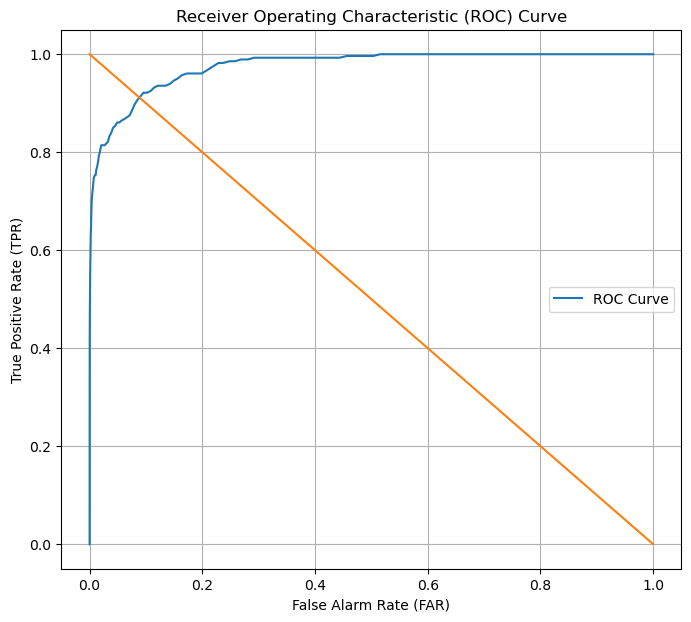

(0.9142857142857143, 0.5428571428571428)

In [69]:
# INSERT CODE HERE
plot_roc(similarity_matrix,recall_at_far_value = 0.001)

    ANS: 
    Minimum threshold : Since the minimum distance between 2 images is maybe 0 (a sum of distance can be mimimal at (1-1)**2)  or more but since threshold = 0 will always yield True so increases it a bit wont be a problem  let's use 0.75 
    MAXIMUM threshold : Since the maximum distance between 2 images is sqrt of 56*46 = 50.75(the total dimension of an image whereas a distance can be at most (1-0)**2) 
    ThereFore therefor THRESHOLD [0.75, 50.75]


### T10. What is the EER (Equal Error Rate)? What is the recall rate at 0.1% false alarm rate? (Write this in the same function as the previous question)


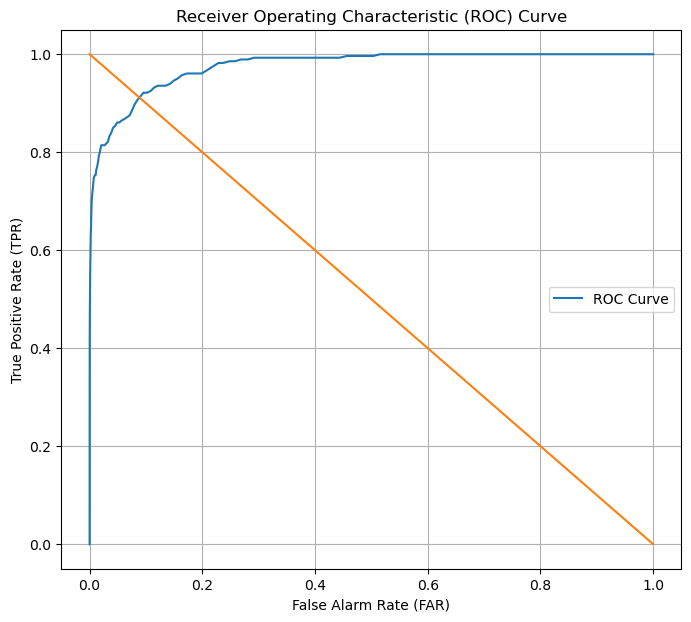

Equal Error Rate = 0.9142857142857143
recall rate at 0.1% FAR = 0.5428571428571428


In [70]:
# You can add more parameter(s) to the function in the previous question.

EER, recall_rate = plot_roc(similarity_matrix,recall_at_far_value = 0.001)
print(f"Equal Error Rate = {EER}\nrecall rate at 0.1% FAR = {recall_rate}")

# EER should be either 0.9071428571428571 or 0.9103759398496248 depending on method.
# Recall rate at 0.1% false alarm rate should be 0.5428571428571428.

    ANS:
    Equal Error Rate = 0.9142857142857143
    recall rate at 0.1% FAR = 0.5428571428571428


### T11. Compute the mean vector from the training images. Show the vector as an image (use numpy.reshape()). This is typically called the meanface (or meanvoice for speech signals). You answer should look exactly like the image shown below.


feature, datapoint
(2576, 120)
meanface shape:  (2576, 1)


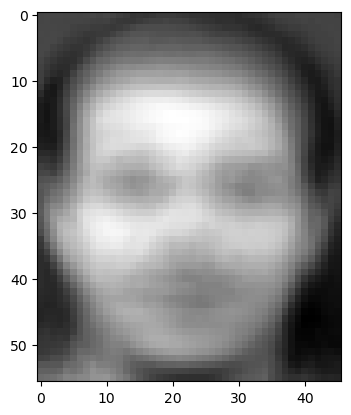

In [71]:
# INSERT CODE HERE
X = T.T
print("feature, datapoint")
print(X.shape)

meanface = np.mean(X, axis=1)
meanface = meanface.reshape(2576, -1)
print("meanface shape: " , meanface.shape)
meanface_matrix = meanface.reshape(56,46)

plt.imshow(meanface_matrix, cmap = 'gray')
plt.show()


![Screenshot 2024-02-21 012250.png](<attachment:Screenshot 2024-02-21 012250.png>)
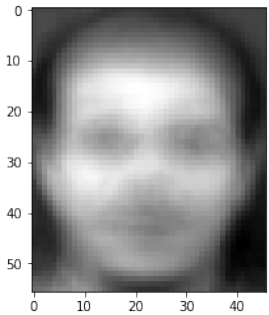

### T12. What is the size of the covariance matrix? What is the rank of the covariance matrix?


In [72]:
# TODO: Find the size and the rank of the covariance matrix.

#training data minus the mean of each feature
#print("meanface" ,meanface.reshape(2576, -1))
#print("Matrix X\n",X)
X_hat= (X - meanface)
print(X_hat.shape)
#covarience Metrix is feature * feature dimension (2576*2576)
covariance_metrix = np.dot(X_hat,X_hat.T)
#find the rank EZ using matrix_rank()
covariance_metrix_rank = np.linalg.matrix_rank(covariance_metrix)


(2576, 120)


In [73]:
print("Covarience Matrix Dimensions : ",  covariance_metrix.shape)
print(f"Covarience Matrix Rank : {covariance_metrix_rank}" )

Covarience Matrix Dimensions :  (2576, 2576)
Covarience Matrix Rank : 119


    ANS:
    Covarience Matrix Dimensions :  (2576, 2576)
    Covarience Matrix Rank : 119


### T13. What is the size of the Gram matrix? What is the rank of Gram matrix? If we compute the eigenvalues from the Gram matrix, how many non- zero eigenvalues do we expect to get?


In [74]:
# TODO: Compute gram matrix.
gram_matrix = np.dot(X_hat.T,X_hat)
gram_matrix_rank = np.linalg.matrix_rank(gram_matrix)

In [75]:
# TODO: Show size and rank of Gram matrix.
print("Gram matrix Dimensions : ",  gram_matrix.shape)
print(f"Gram Matrix Rank : {gram_matrix_rank}" )

Gram matrix Dimensions :  (120, 120)
Gram Matrix Rank : 119


    ANS:
    Gram matrix Dimensions :  (120, 120)
    Gram Matrix Rank : 119

    expected non-zero eigenvalues 119 at most


## T14. Is the Gram matrix also symmetric? Why?


    ANS: Yes, as it came from the a product of a Metrix and its transpose which have the symmetric property like in class said


### T15. Compute the eigenvectors and eigenvalues of the Gram matrix, v 0 and λ. Sort the eigenvalues and eigenvectors in descending order so that the first eigenvalue is the highest, and the first eigenvector corresponds to the best direction. How many non-zero eigenvalues are there? If you see a very small value, it is just numerical error and should be treated as zero.


In [76]:
# Hint: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html

def calculate_eigenvectors_and_eigenvalues(matrix):
    """
    TODO: Calculate eigenvectors and eigenvalues,
    then sort the eigenvalues and eigenvectors in descending order.

    Hint: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
    """

    # INSERT CODE HERE
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    return eigenvalues_sorted, eigenvectors_sorted

eigenvalues, eigenvectors = calculate_eigenvectors_and_eigenvalues(gram_matrix)

def test_eigenvalues_eigenvectors():
    # Dot product of an eigenvector pair should equal to zero.
    assert np.round(eigenvectors[10].dot(eigenvectors[20]), 10) == 0.0

    # Check if eigenvalues are sorted.
    assert list(eigenvalues) == sorted(eigenvalues, reverse = True)

test_eigenvalues_eigenvectors()

In [77]:
non_zero_eigenValues = np.sum(eigenvalues > 1e-10)
print("non-zero Eigen Values : ",non_zero_eigenValues)

non-zero Eigen Values :  119


    ANS: 
    non-zero Eigen Values :  119

    just as much as the rank of the matrix




### T16. Plot the eigenvalues. Observe how fast the eigenvalues decrease. In class, we learned that the eigenvalues is the size of the variance for each eigenvector direction. If I want to keep 95% of the variance in the data, how many eigenvectors should I use?


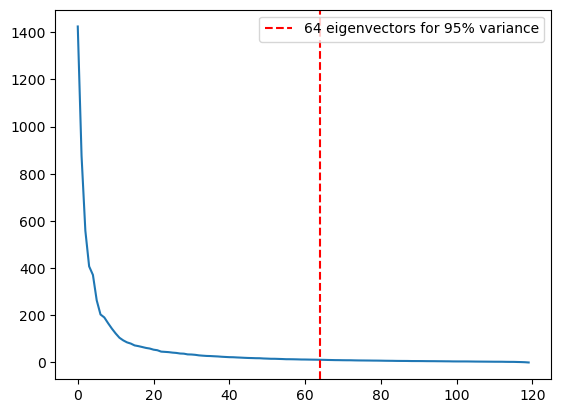

Number of eigenvectors to keep 95% of the variance: 64


In [78]:
# INSERT CODE HERE


# Calculate the total sum of eigenvalues
total_variance = np.sum(eigenvalues)

# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Determine the number of eigenvectors to keep 95% of the variance
desired_variance_ratio = 0.95
num_eigenvectors = np.argmax(cumulative_variance_ratio >= desired_variance_ratio) + 1

x = np.linspace(0,119,120)
plt.plot(x,eigenvalues)
plt.axvline(x=num_eigenvectors, color='red', linestyle='--', label=f'{num_eigenvectors} eigenvectors for 95% variance')
plt.legend()
plt.show()

print("Number of eigenvectors to keep 95% of the variance:", num_eigenvectors)


    ANS: 64 EigenVector for 95% varience


### T17. Compute $\vec{v}$ . Don’t forget to renormalize so that the norm of each vector is 1 (you can use numpy.linalg.norm). Show the first 10 eigenvectors as images. Two example eigenvectors are shown below. We call these images eigenfaces (or eigenvoice for speech signals).


In [79]:
# TODO: Compute v, then renormalize it.

# INSERT CODE HERE
# v = X_hat * v'
covarience_metrix_eigenvectors = np.dot(X_hat,eigenvectors)
covarience_metrix_eigenvectors = covarience_metrix_eigenvectors / np.linalg.norm(covarience_metrix_eigenvectors, axis = 0)

v = covarience_metrix_eigenvectors
print(X_hat.shape)
print(covarience_metrix_eigenvectors.shape)

(2576, 120)
(2576, 120)


In [80]:
def test_eignevector_cov_norm(v):
    assert (np.round(np.linalg.norm(v, axis=0), 1) == 1.0).all()

test_eignevector_cov_norm(v)

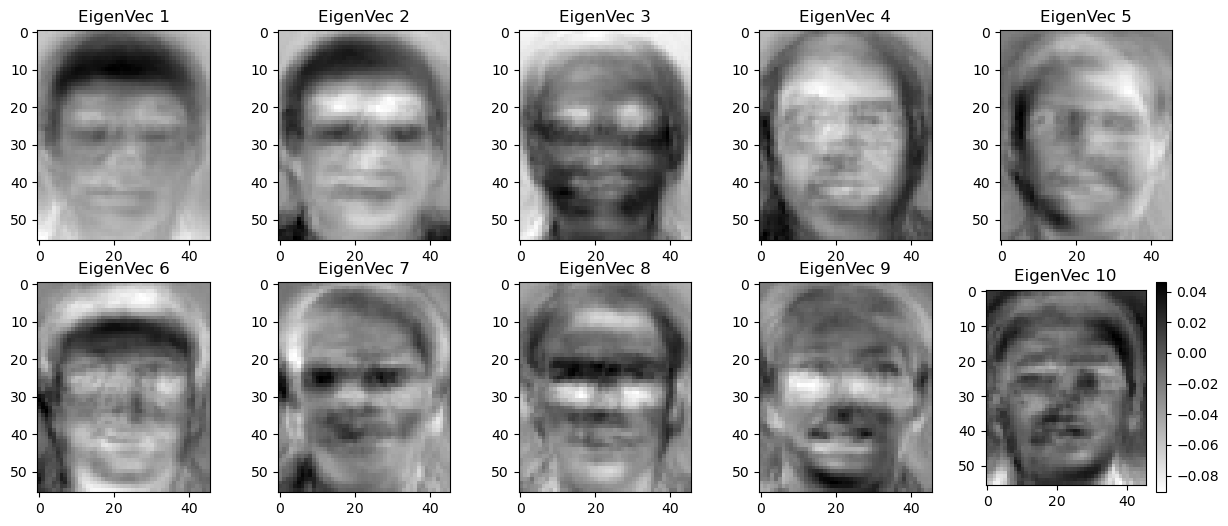

In [81]:
# TODO: Show the first 10 eigenvectors as images.
num_eigenvectors_to_show = 10
rows = 2
cols = 5

plt.figure(figsize=(15, 6))

for img_index in range(num_eigenvectors_to_show):
    plt.subplot(rows, cols, img_index + 1)
    eigenvector_image = np.reshape(v[:, img_index], (56, 46))
    plt.imshow(eigenvector_image, cmap="binary")
    plt.title(f'EigenVec {img_index + 1}')
plt.colorbar()
plt.show()

# plt.imshow(meanface_matrix, cmap = 'binary')
# plt.show()

### T18. From the image, what do you think the first eigenvector captures? What about the second eigenvector? Look at the original images, do you think biggest variance are capture in these two eigenvectors?


    ANS: 
    The First eigenvector probably capture the differences in hair and a bit of eye.
    The Second eigenvector, Capture Hair Eye mouth and around the shoulder area

from CHATGPT: 
In the context of PCA and eigenfaces, a high positive value for an element in an eigenvector indicates a "strong positive correlation" between the corresponding pixel in the original images and the structure represented by that eigenvector.

Conversely, a high negative value for an element in an eigenvector indicates a strong negative correlation, implying that a decrease in intensity of that pixel is associated with a stronger presence of the corresponding facial feature in the eigenface.

### T19. Find the projection values of all images. Keep the first k = 10 projection values. Repeat the simple face verification system we did earlier using these projected values. What is the EER and the recall rate at 0.1% FAR?


In [82]:
def calculate_projection_vectors(matrix, meanface, v):
    """    TODO: Find the projection vectors on v from given matrix and meanface.
    projection_vector's' = V.T @ (x_vec - x_mean_vec) where v is all da eigenvectors

    Args:
        matrix (_type_): X_hat
        meanface (_type_): meanface
        v (_type_): covarience_metrix_eigenvectors with first k eigen vec

    Returns:
        projection_vector.T metrix: row is datapoint col is the feature
    """
    #print("meanface shape" ,meanface.shape)
    #print("v.T shape" ,v.T.shape)
    #print("dataHat shape" ,matrix.shape)
    projection_vectors = np.dot(v.T,(matrix - meanface))

    return projection_vectors.T

In [83]:
# TODO: Get projection vectors of T and D, then Keep first k projection values.
T_X = T.T
D_X = D.T
T_X_hat = (T_X - meanface)
D_X_hat = (D_X- meanface)

k = 10

T_reduced = calculate_projection_vectors(T_X_hat,meanface,covarience_metrix_eigenvectors[:,:k])
print("=-----------------------=")
D_reduced = calculate_projection_vectors(D_X_hat,meanface,covarience_metrix_eigenvectors[:,:k])
print("(datapoint,feature)",T_reduced.shape)

def test_reduce_dimension():
    assert T_reduced.shape[-1] == k
    assert D_reduced.shape[-1] == k

test_reduce_dimension()

=-----------------------=
(datapoint,feature) (120, 10)


similarity_matrix_reduced :  (120, 280)


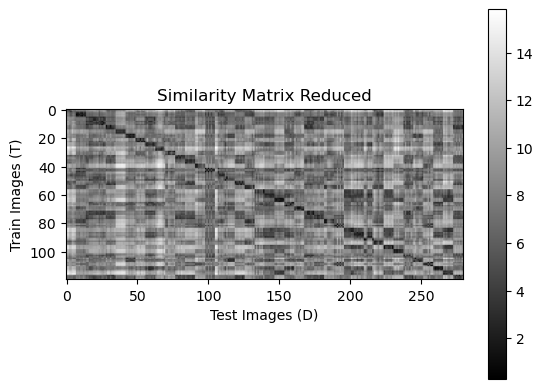

In [84]:
# TODO: Get similarity matrix of T_reduced and D_reduced
similarity_matrix_reduced = generate_similarity_matrix(T_reduced,D_reduced)
print("similarity_matrix_reduced : ", similarity_matrix_reduced.shape)
plot_similarity_matrix("Reduced",similarity_matrix_reduced)

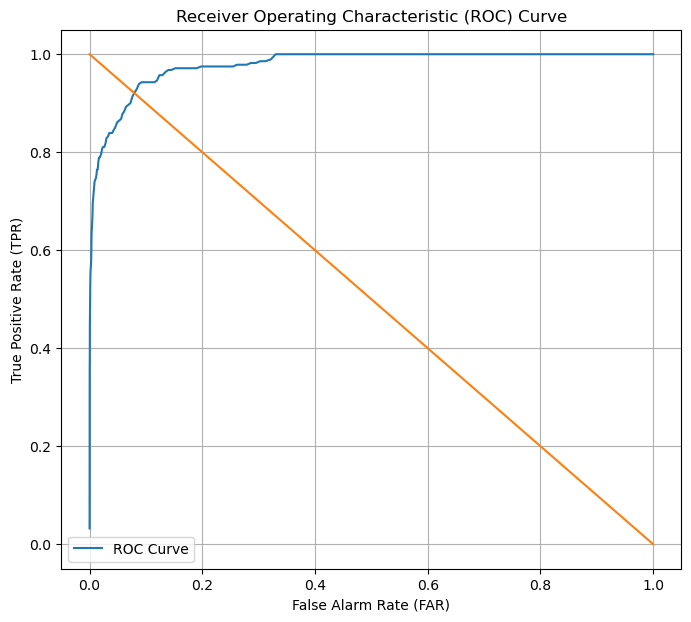

Equal Error Rate of_reduced = 0.9214285714285714
recall rate of_reduced at 0.1% FAR = 0.4785714285714286


In [85]:
# TODO: Find EER and the recall rate at 0.1% FAR.

EER_reduced, recall_rate_reduced = plot_roc(similarity_matrix_reduced,recall_at_far_value = 0.001)
print(f"Equal Error Rate of_reduced = {EER_reduced}\nrecall rate of_reduced at 0.1% FAR = {recall_rate_reduced}")

    ANS:
    Equal Error Rate of_reduced = 0.9214285714285714
    recall rate of_reduced at 0.1% FAR = 0.4785714285714286


### T20. What is the k that gives the best EER? Try k = 5, 6, 7, 8, 9, 10, 11, 12, 13, 14.


In [86]:
# INSERT CODE HERE
print("=====================================================")
EER_list = []
recall_rate_list = []
for number_of_k in [5,6,7,8,9,10,11,12,13,14]:

    _T_reduced = calculate_projection_vectors(T_X_hat,meanface,covarience_metrix_eigenvectors[:,:number_of_k])
    _D_reduced = calculate_projection_vectors(D_X_hat,meanface,covarience_metrix_eigenvectors[:,:number_of_k])

    _similarity_matrix_reduced = generate_similarity_matrix(_T_reduced,_D_reduced)
    #print("similarity_matrix_reduced : ", _similarity_matrix_reduced.shape)
    
    EER_reduced, recall_rate_reduced = plot_roc(_similarity_matrix_reduced,recall_at_far_value = 0.001,showplot=False)
    
    EER_list.append(EER_reduced)
    recall_rate_list.append(recall_rate_reduced)
    print(f"(K = {number_of_k})EER = {EER_reduced}     recall rate at 0.1% FAR = {recall_rate_reduced}")
    print("=====---------------------=====")
    
print(f"MAX EER : {np.max(EER_list)} at k={np.argmax(EER_list) + 5}")
print(f"MAX recall_rate at 0.1% FAR : {np.max(recall_rate_list)} at k={np.argmax(recall_rate_list)}" )

(K = 5)EER = 0.8928571428571429     recall rate at 0.1% FAR = 0.25357142857142856
=====---------------------=====
(K = 6)EER = 0.9071428571428571     recall rate at 0.1% FAR = 0.3464285714285714
=====---------------------=====
(K = 7)EER = 0.9071428571428571     recall rate at 0.1% FAR = 0.4142857142857143
=====---------------------=====
(K = 8)EER = 0.9142857142857143     recall rate at 0.1% FAR = 0.40714285714285714
=====---------------------=====
(K = 9)EER = 0.9214285714285714     recall rate at 0.1% FAR = 0.44285714285714284
=====---------------------=====
(K = 10)EER = 0.9214285714285714     recall rate at 0.1% FAR = 0.4785714285714286
=====---------------------=====
(K = 11)EER = 0.9214285714285714     recall rate at 0.1% FAR = 0.5071428571428571
=====---------------------=====
(K = 12)EER = 0.9142857142857143     recall rate at 0.1% FAR = 0.5035714285714286
=====---------------------=====
(K = 13)EER = 0.9178571428571428     recall rate at 0.1% FAR = 0.5035714285714286
=====---

    ANS:
    MAX EER : 0.9214285714285714 at k=9
    MAX recall_rate at 0.1% FAR : 0.5071428571428571 at k=6


### OT2. Reconstruct the first image using this procedure. Use k = 10, what is the MSE?

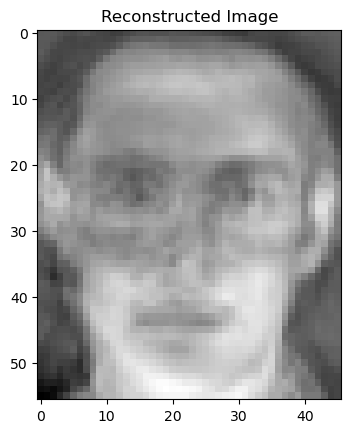

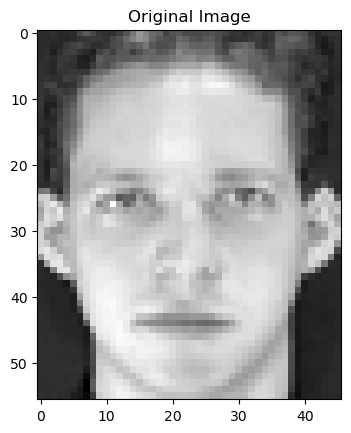

Mean Squared Error (MSE): 0.20668668617074118


In [87]:
# Assuming calculate_projection_vectors function is correctly implemented

# Calculate projection vectors using the first 10 eigenvectors
elMean = np.mean(T_X_hat, axis=0).reshape(1, -1)
re_project = calculate_projection_vectors(T_X_hat, elMean, covarience_metrix_eigenvectors)[:, :10][0]

# Reconstruct the image using the projection vectors and eigenvectors
re_pic = np.dot(covarience_metrix_eigenvectors[:, :10], re_project).reshape((56, 46)) + elMean.T[0]

# Visualize the reconstructed image
plt.imshow(re_pic, cmap="gray")
plt.title("Reconstructed Image")
plt.show()

# Visualize the original image
plt.imshow(xf[0, 0], cmap="gray")
plt.title("Original Image")
plt.show()

# Calculate MSE between the original and reconstructed images
mse_value = np.mean((xf[0, 0] - re_pic) ** 2)

# Print the MSE value
print("Mean Squared Error (MSE):", mse_value)


### T21. In order to assure that $S_W$ is invertible we need to make sure that $S_W$ is full rank. How many PCA dimensions do we need to keep in order for $S_W$ to be full rank? (Hint: How many dimensions does $S_W$ have? In order to be of full rank, you need to have the same number of linearly independent factors)


    ANS: 
    from rank S_w = (Number of train datapoints) - (Number of Class)
    Therefore rank S_w to keep = 80 = 120 - 40


In [88]:
# TODO: Find the LDA projection.
def calculate_between_class_scatter(data_reduced_metrix):
    
    # Assuming data is organized in three consecutive rows as one class using numpy.reshape
    class_data = np.reshape(data_reduced_metrix, (-1, 3, data_reduced_metrix.shape[1]))
    
    overall_mean = np.mean(class_data, axis=(0, 1)).reshape(1, -1)
    
    between_class_scatter = np.zeros((data_reduced_metrix.shape[1], data_reduced_metrix.shape[1]))
    
    for i in range(class_data.shape[0]):
        class_mean_vector = np.mean(class_data[i], axis=0).reshape(1, -1)
        between_class_scatter += 3 * (class_mean_vector - overall_mean).T @ (class_mean_vector - overall_mean)
    
    print("between_class_scatter", between_class_scatter.shape)
    
    return between_class_scatter

def calculate_within_class_scatter(data_reduced_metrix):
    # Assuming data is organized in three consecutive rows as one class using numpy.reshape
    class_data = np.reshape(data_reduced_metrix, (-1, 3, data_reduced_metrix.shape[1]))
    
    within_class_scatter = np.zeros((data_reduced_metrix.shape[1], data_reduced_metrix.shape[1]))
    
    for i in range(class_data.shape[0]):
        class_mean_vector = np.mean(class_data[i], axis=0).reshape(1, -1)
        class_scatter = (class_data[i] - class_mean_vector).T @ (class_data[i] - class_mean_vector)
        within_class_scatter += class_scatter
    
    print("within_class_scatter", within_class_scatter.shape)
    return within_class_scatter


In [89]:
# TODO: Define dimension of PCA.
n_dim = 80

# TODO: Find PCA of T and D with n_dim dimension.
T_reduced80 = calculate_projection_vectors(T_X_hat, meanface, covarience_metrix_eigenvectors[:,:n_dim])
D_reduced80 = calculate_projection_vectors(D_X_hat, meanface, covarience_metrix_eigenvectors[:,:n_dim])

print(T_reduced80.shape)
print(D_reduced80.shape)

(120, 80)
(280, 80)


### T22. Using the answer to the previous question, project the original in- put to the PCA subspace. Find the LDA projections. To find the inverse, use −1 numpy.linalg.inv. Is $S_W$ $S_B$ symmetric? Can we still use numpy.linalg.eigh? How many non-zero eigenvalues are there?


In [90]:
# TODO: Find the LDA projection.

T_SB = calculate_between_class_scatter(T_reduced80)
T_SW = calculate_within_class_scatter(T_reduced80)

T_SW_inv = np.linalg.inv(T_SW)


print("T_SB", T_SB.shape)
print("T_SW", T_SW.shape)
print("T_SW_inv",T_SW_inv.shape)

SW_inv_prod_SB = T_SW_inv @ T_SB

print("SW_inv_prod_SB",SW_inv_prod_SB.shape)

#check if SW_inv_prod_SB is symmetric 
isSymmetric = (SW_inv_prod_SB == SW_inv_prod_SB.T).all()
print("is SW_inv_prod_SB Symmetric? :", isSymmetric)

between_class_scatter (80, 80)
within_class_scatter (80, 80)
T_SB (80, 80)
T_SW (80, 80)
T_SW_inv (80, 80)
SW_inv_prod_SB (80, 80)
is SW_inv_prod_SB Symmetric? : False


In [91]:
def calculate_eigenvectors_and_eigenvalues_non_symmetrix(matrix):
    """
    Calculate eigenvectors and eigenvalues,
    then sort the eigenvalues and eigenvectors in descending order.

    :param matrix: The input matrix.
    :return: Tuple of sorted eigenvalues and corresponding eigenvectors. with cast to .real
    """
    # Calculate eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    return eigenvalues_sorted.real, eigenvectors_sorted.real



In [92]:
# TODO: Find how many non-zero eigenvalues there are.

eigenvalues_LDA, eigenvectors_LDA = calculate_eigenvectors_and_eigenvalues_non_symmetrix(SW_inv_prod_SB)

non_zero_eigenvalues_LDA = np.sum(eigenvalues_LDA > 1e-8)
print("non-zero Eigen Values : ",non_zero_eigenvalues_LDA)

non-zero Eigen Values :  39


    ANS: 
    Is it symmetric? : NO as a resluts we can't use numpy.linalg.eigh
    Therefore we must use numpy.linalg.eig instead,
    
    Also non-zero Eigen Values = 39 
    (depend on the calculation errror if epsilon really low it might changes but this value follows C-1 Rule)


### T23. Plot the first 10 LDA eigenvectors as images (the 10 best projections). Note that in this setup, you need to convert back to the original image space by using the PCA projection. The LDA eigenvectors can be considered as a linear combination of eigenfaces. Compare the LDA projections with the PCA projections.


(120, 80)
(80, 80)
(2576, 80)
(1, 80)


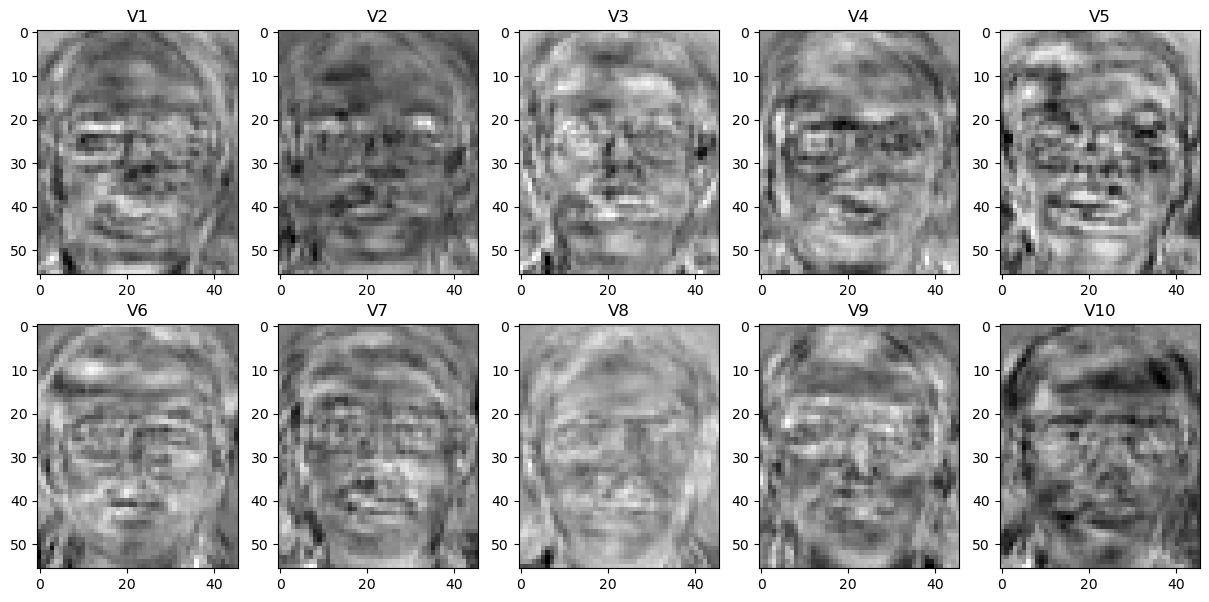

In [93]:
covarience_metrix_eigenvectors_first80 = covarience_metrix_eigenvectors[:, :80]

print(T_reduced80.shape)
print(eigenvectors_LDA.shape)
print(covarience_metrix_eigenvectors_first80.shape)

meanface_vector = np.mean(T_reduced80, axis=0).reshape(1, -1)
print(meanface_vector.shape)
Reconst = (covarience_metrix_eigenvectors_first80 @ eigenvectors_LDA)+meanface_vector

fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(np.reshape(Reconst[:, i], (56, 46)), cmap = "gray")
    ax.set_title(f"V{i+1}")

plt.show()

### T24. The combined PCA+LDA projection procedure is called fisherface. Calculate the fisherfaces projection of all images. Do the simple face verification experiment using fisherfaces. What is the EER and recall rate at 0.1% FAR?


(80, 120)
(80, 1)
(80, 39)
--------------------------
(120, 39)
(280, 39)
(120, 280)


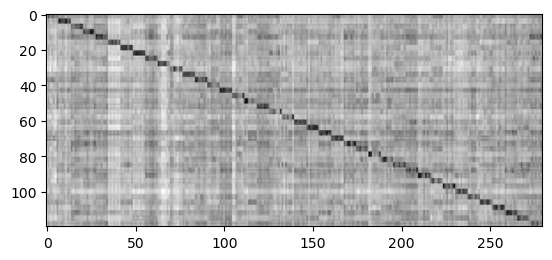

In [94]:
print(T_reduced80.T.shape)
print(meanface_vector.T.shape)
print(eigenvectors_LDA[:,:39].shape)

T_non_zero_EV = calculate_projection_vectors(T_reduced80.T,meanface_vector.T,eigenvectors_LDA[:,:39])
D_non_zero_EV = calculate_projection_vectors(D_reduced80.T,meanface_vector.T,eigenvectors_LDA[:,:39])

similarity_matrix_non_zero_EV = generate_similarity_matrix(T_non_zero_EV, D_non_zero_EV)

print("--------------------------")
print(T_non_zero_EV.shape)
print(D_non_zero_EV.shape)
print(similarity_matrix_non_zero_EV.shape)

plt.imshow(similarity_matrix_non_zero_EV, cmap ="gray")
plt.show()

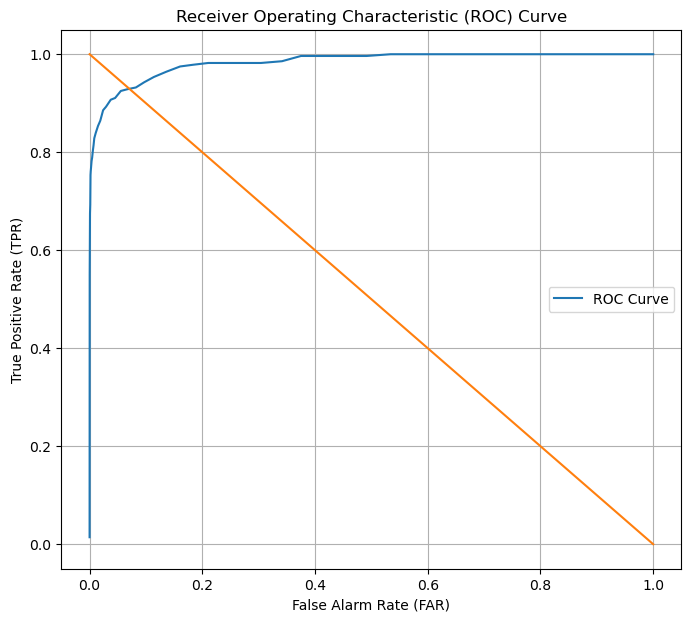

EER = 0.9285714285714286, recall rate at 0.1% FAR = 0.6928571428571428


In [95]:
EER_non_zero_EV , recall_rate_non_zero_EV  = plot_roc(similarity_matrix_non_zero_EV, 0.001)
print(f"EER = {EER_non_zero_EV}, recall rate at 0.1% FAR = {recall_rate_non_zero_EV}")

    ANS:
    EER = 0.9285714285714286, recall rate at 0.1% FAR = 0.5785714285714286


### T25.Plot the RoC of all three experiments (No projection, PCA, andFisher) on the same axes. Compare and contrast the three results. Submit yourwriteup and code on MyCourseVille.


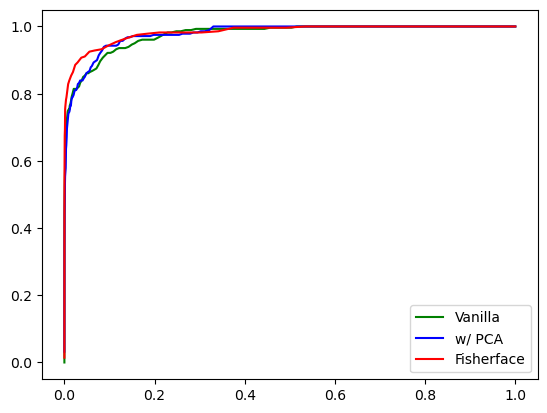

ZOOOOOOOOMED IN


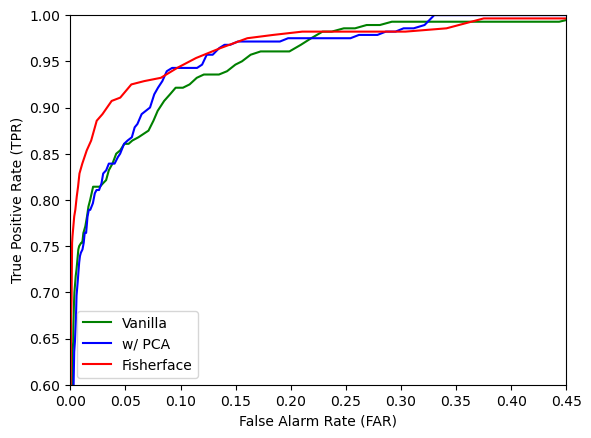

In [96]:
TPR_tmp, FAR_tmp  = calculate_roc(similarity_matrix)
plt.plot(FAR_tmp, TPR_tmp, color = "green")
TPR_tmp, FAR_tmp = calculate_roc(similarity_matrix_reduced)
plt.plot(FAR_tmp, TPR_tmp, color = "blue")
TPR_tmp, FAR_tmp = calculate_roc(similarity_matrix_non_zero_EV)
plt.plot(FAR_tmp, TPR_tmp, color = "red")
plt.legend(["Vanilla", "w/ PCA", "Fisherface"])
plt.show()


print("ZOOOOOOOOMED IN")
TPR_tmp, FAR_tmp  = calculate_roc(similarity_matrix)
plt.plot(FAR_tmp, TPR_tmp, color="green")

TPR_tmp, FAR_tmp = calculate_roc(similarity_matrix_reduced)
plt.plot(FAR_tmp, TPR_tmp, color="blue")

TPR_tmp, FAR_tmp = calculate_roc(similarity_matrix_non_zero_EV)
plt.plot(FAR_tmp, TPR_tmp, color="red")

plt.legend(["Vanilla", "w/ PCA", "Fisherface"])
plt.xlabel("False Alarm Rate (FAR)")
plt.ylabel("True Positive Rate (TPR)")

# Set x-axis and y-axis limits for zooming in
plt.xlim([0.0, 0.45])
plt.ylim([0.6, 1.0])

plt.show()

    ANS: 
    We can see that the fisherFace method mostly perform better at the same False Alarm Rate while maintaining compact dimensions features
    While PCA might perform similiary to Vanilla but it uses very little computation (fr fr no cap)